### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

1) MSE  $-\frac{dL}{dF}(x_i,F_{k-1}(x_i)) =  2 * (y_i - F_{k-1}(x_i)) $

2) Экспоненциальная  $-\frac{dL}{dF}(x_i,F_{k-1}(x_i))  = y_i * exp( -F_{k-1}(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $-\frac{dL}{dF}(x_i,F_{k-1}(x_i))  = \frac{y_i * exp( -F_{k-1}(x_i) y_i)}{1 + exp( -F_{k-1}(x_i) y_i) }, y_i \in \{-1, 1\}$


##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [70]:
class MyGradientBoostingClassifier:

    def __init__(self, loss_='MSE', learning_rate_=0.1, n_estimators_=100, colsample_=1, subsample_=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss_
        self.learning_rate = learning_rate_
        self.n_estimators = n_estimators_
        self.colsample = colsample_
        self.subsample = subsample_
        self.kwargs = kwargs
        self.args = args
    
    def get_params(self, deep = True):
         return {
            'loss_' : self.loss, 
            'learning_rate_' : self.learning_rate, 
            'n_estimators_' : self.n_estimators,
            'colsample_' : self.colsample, 
            'subsample_' : self.subsample
        }
    
    def set_params(self, **kwargs):
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self
    
    def grad(self, X, y):
        if self.loss == 'MSE':
            grad = 2 * (y - self.predict(X))
        elif self.loss == 'EXP':
            grad = y * np.exp(- self.predict(X) * y)
        else:
            exp =  np.exp(- self.predict(X) * y )
            grad = y * exp / (1 + exp)
        return grad
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.models = []
        self.init_model = None
        feature_amount = min(X.shape[1], int(X.shape[1] *  self.colsample  + 1))
        objects_amount = min(X.shape[0], int(X.shape[0] *  self.subsample + 1))
        if init_model is not None:
            self.init_model = init_model()
            self.init_model.fit(X, y)
        for i in range(1, self.n_estimators + 1):
            f_k = base_model(*self.args, **self.kwargs)
            features_choosen = np.random.choice(np.arange(X.shape[1]), feature_amount, False)
            objects_choosen = np.random.choice(np.arange(X.shape[0]), objects_amount, False)
            X_choosen = X[np.ix_(objects_choosen, features_choosen)]
            y_choosen = y[objects_choosen]
            f_k.fit(X_choosen, self.grad(X[objects_choosen], y_choosen))
            #f_k.fit(X, self.grad(X, y))
            self.models.append((f_k,features_choosen))
            
        
    def predict(self, X):
        if self.init_model == None:
            res = np.zeros(X.shape[0])
        else:
            res = self.init_model.predict(X)
        for model in self.models:
            X_choosen = X[:, model[1]]
            #X_choosen = X
            res += self.learning_rate * model[0].predict(X_choosen)
        return np.rint(res).astype(int)



In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

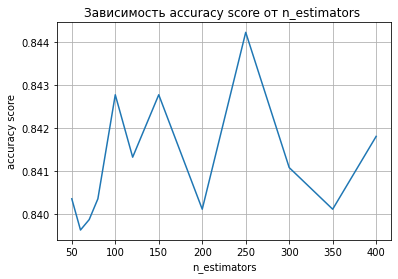

In [34]:
n_estimators = [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300, 350, 400]
res = []

for n in n_estimators:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = n)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(n_estimators, res)
ax.grid()

ax.set_title('Зависимость accuracy score от n_estimators ')

ax.set_xlabel('n_estimators')
ax.set_ylabel('accuracy score')

plt.show()    

## Подбираю параметры

Text(0.5, 0, 'loss')

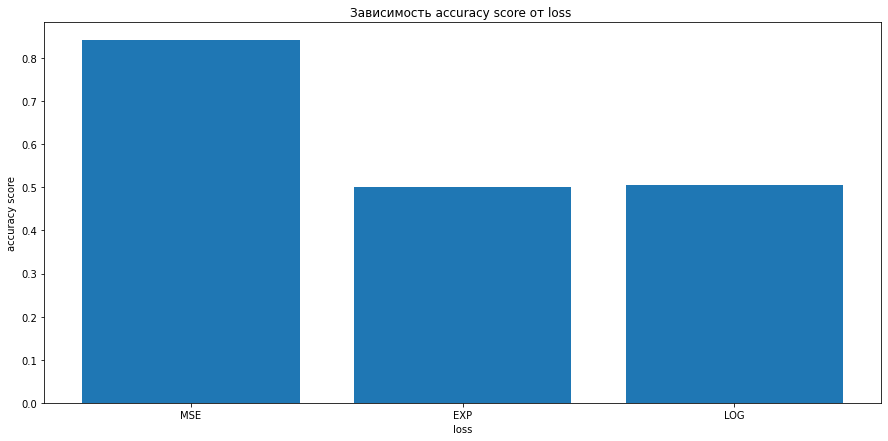

In [35]:
loss = ['MSE', 'EXP', 'LOG']
res = []

for l in loss:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = 100, loss_ = l)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Зависимость accuracy score от loss ')
ax.bar(loss, res)
ax.set_ylabel('accuracy score')
ax.set_xlabel('loss')  

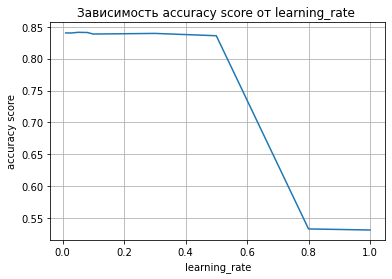

In [36]:
lr = [0.01, 0.03, 0.05, 0.08, 0.1,0.3, 0.5, 0.8, 1.0]
res = []

for l in lr:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = 120, loss_ = 'MSE', learning_rate_ = l)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(lr, res)
ax.grid()

ax.set_title('Зависимость accuracy score от learning_rate ')

ax.set_xlabel('learning_rate')
ax.set_ylabel('accuracy score')

plt.show()    


In [37]:
lr[np.argmax(res)]

0.05

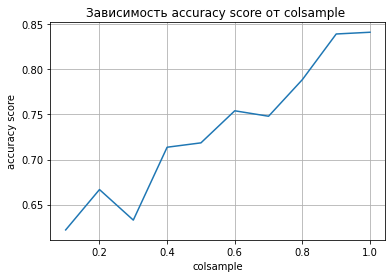

In [38]:
cs = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]
res = []

for c in cs:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = 100, loss_ = 'MSE', learning_rate_ = 0.05, colsample_ = c)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(cs, res)
ax.grid()

ax.set_title('Зависимость accuracy score от colsample ')

ax.set_xlabel('colsample')
ax.set_ylabel('accuracy score')

plt.show()    


In [39]:
cs[np.argmax(res)]

1.0

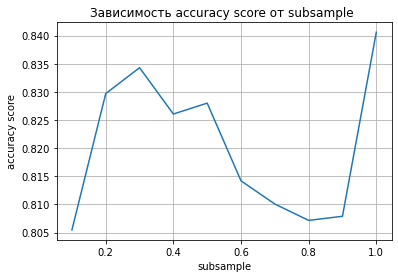

In [41]:
ss = [0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7,0.8, 0.9, 1.0]
res = []

for s in ss:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = 100, loss_ = 'MSE', learning_rate_ = 0.05, colsample_ = 1.0, subsample_ = s)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(ss, res)
ax.grid()

ax.set_title('Зависимость accuracy score от subsample ')

ax.set_xlabel('subsample')
ax.set_ylabel('accuracy score')

plt.show()    

In [47]:
my_clf = MyGradientBoostingClassifier(n_estimators_ = 100, loss_ = 'MSE', learning_rate_ = 0.05, colsample_ = 1.0, subsample_ = 1.0)
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8406007751937985

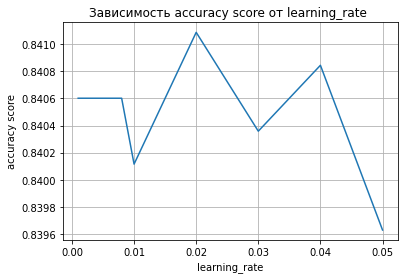

In [49]:
lr = [0.001, 0.005, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05]
res = []

for l in lr:
    my_clf = MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = l,  colsample_ = 1.0, subsample_ = 1.0)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(lr, res)
ax.grid()

ax.set_title('Зависимость accuracy score от learning_rate ')

ax.set_xlabel('learning_rate')
ax.set_ylabel('accuracy score')

plt.show()    

In [52]:
my_clf = MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = 0.02,  colsample_ = 1.0, subsample_ = 1.0)
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8410852713178295

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

# 1

In [53]:
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier

In [54]:
my_clf.fit(X_train, y_train, base_model = RandomForestRegressor)

In [55]:
y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.7693798449612403

Результат стал хуже. 

# 2

In [61]:
bag_clf = BaggingClassifier(base_estimator =  MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = 0.02,  colsample_ = 1.0, subsample_ = 1.0), n_estimators = 20)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=<__main__.MyGradientBoostingClassifier object at 0x0000021CDCBEF100>,
                  n_estimators=20)

In [62]:
accuracy_score(y_pred=bag_clf.predict(X_test), y_true=y_test)

0.8706395348837209

Результат стал лучше, так как несколько моделей с большей вероятностью угадают правильный ответ, чем одна

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [71]:
from sklearn.linear_model import LinearRegression

my_clf = MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = 0.02,  colsample_ = 1.0, subsample_ = 1.0)
my_clf.fit(X_train, y_train, init_model = LinearRegression)

y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8551356589147286

In [72]:
from sklearn.svm import SVR

my_clf = MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = 0.02,  colsample_ = 1.0, subsample_ = 1.0)
my_clf.fit(X_train, y_train, init_model = SVR)

y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8103197674418605

In [73]:
my_clf = MyGradientBoostingClassifier(n_estimators_ = 250, loss_ = 'MSE', learning_rate_ = 0.02,  colsample_ = 1.0, subsample_ = 1.0)
my_clf.fit(X_train, y_train, init_model = RandomForestRegressor)

y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8871124031007752

Качество немного улучашется, так как инициализация с начальной моделью позволяет найти еще больше зависимостей в данных

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

